In [1]:
import numpy as np
import matplotlib.pyplot as plt
from integral import integral_CrudeMC

## PLOTTA GRAFICO DI F SOMMATO A GAUSSIANA NORMALIZZATA 2

area della gaussiana non standardizzata = 1.0183835660438718
coefficiente normalizzazione 2 = 1.9638965775630361


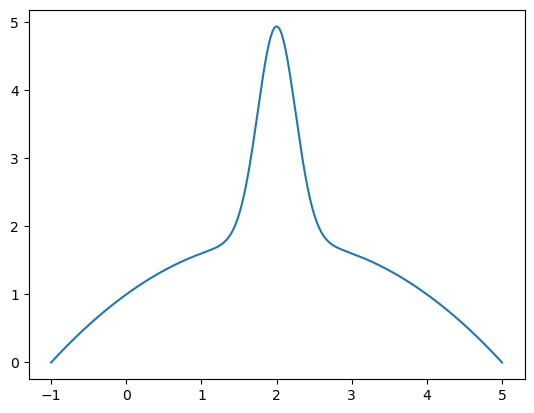

In [2]:
def f(x, a = -0.2, b = 0.8, c = 1.0):
    return a * x ** 2 + b * x + c

def gaussian(x, mu = 2, sigma = 0.25):
    return (1/(sigma * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mu)/sigma) ** 2)
    
#NORMALIZZAZIONE 2
area_gauss, std_dev = integral_CrudeMC(gaussian, -2, 6, 10000)
print(f'area della gaussiana non standardizzata = {area_gauss}')
normz = 2* float(area_gauss**(-1))
print(f'coefficiente normalizzazione 2 = {normz}')

def total(x, a = -0.2, b = 0.8, c = 1.0, mu = 2, sigma = 0.25):
    y = a * x ** 2 + b * x + c
    g = normz * (1/(sigma * np.sqrt(2*np.pi))) * np.exp(-0.5 * ((x-mu) /sigma)**2)
    return y + g

x = np.linspace(-1, 5, 1000)
funz = total(x)
fig, ax = plt.subplots(ncols = 1, nrows = 1)
plt.plot(x, funz);

## TRY AND CATCH

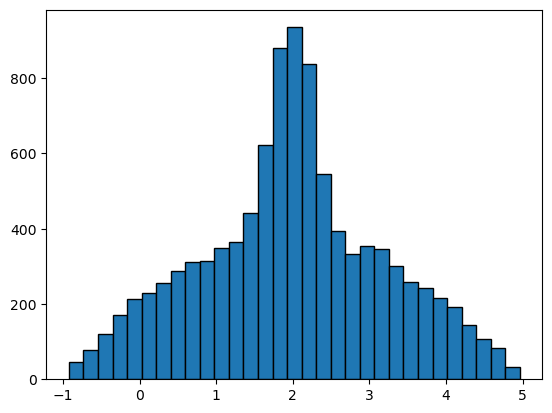

In [5]:
def sturges(N_e):
    return int(np.ceil(1 + 3.322 * np.log(N_e)))

from myrand import generate_TAC
from iminuit import Minuit
from iminuit.cost import LeastSquares

N = 10000

dati = generate_TAC(total, -1, 5, np.max(funz), N)
bin = sturges(N)
bin_edge = np.linspace(np.min(dati), np.max(dati), bin)
plt.hist(dati, bin_edge, edgecolor = 'black');

## FIT 

In [6]:
from iminuit.cost import ExtendedBinnedNLL
from scipy.stats import norm

bin_content, bin_edges = np.histogram(dati, bin)

#--------------------DEFINING TOTAL MODEL-------------------------------------------------------------------------------------

def PDF(bin_edges, N_background, a, b, c, N_signal, n, mu, sigma):
    return N_background * ((1./3.) * a * bin_edges**3 + (1./2.) * b * bin_edges**2. + c * bin_edges) + \
    N_signal * n * norm.cdf(bin_edges, mu, sigma)

#---------------------FIT WITH PRELIMINARY ESTIMATES FOR PARAMETERS-----------------------------------------------------------

my_cost_func = ExtendedBinnedNLL(bin_content, bin_edges, PDF)
fit = Minuit(my_cost_func, N_background = N, a = -0.2, b = 0.8, c = 1., N_signal = N, n = 2, mu = np.mean(dati), sigma = np.std(dati))

#--------------------AIUTO MINUIT IDENTIFICANDO PARAMETRI POSITIVI O NEGATIVI-------------------------------------------------

#bound parameters to be positive
fit.limits['N_background', 'b', 'c', 'N_signal', 'n', 'mu', 'sigma'] = (0, None)
#bound parameters to be negative
fit.limits['a'] = (None, 0)

#---------------------BACKGROUND-----------------------------------------------------------------------------------------------

#faccio fit preliminare rimuovendo i dati associati alla seconda funzione (setto signal a 0)

fit.values['N_signal'] = 0
fit.fixed['N_signal', 'n', 'mu', 'sigma'] = True 

#temporarily mask out the signal - fitting only before 1.5 and after 2.5

bin_centres = 0.5 * (bin_edges[1:] + bin_edges[:-1])
my_cost_func.mask = (bin_centres < 1.5)|(bin_centres > 2.5) #guessed looking at preliminary histogram
fit.migrad()

#--------------------SIGNAL (background parameters found fixed)----------------------------------------------------------------

my_cost_func.mask = None  #removing mask
fit.fixed = False
fit.fixed['N_background', 'a', 'b', 'c'] = True
fit.values['N_signal'] = N - fit.values['N_background']  #finding N_signal as N_tot - N_background
fit.migrad()

#------------------FINAL FIT--------------------------------------------------------------------------------------------------

fit.fixed = False  #rilascio tutti i parametri
fit.migrad()
fit.hesse()
fit.minos()


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 18.97 (χ²/ndof = 0.8)      │             Nfcn = 18722             │
│ EDM = 1.13e-07 (Goal: 0.0002)    │            time = 2.3 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │     Covariance FORCED pos. def.      │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name         │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ N_background │    970    │    50     │    -50     │     50     │    0    │         │       │
│ 1 │ a            │  -0.226   │   0.011   │   -0.011   │   0.011    │         │    0    │       │
│ 2 │ b            │   0.90    │   0.04    │   -0.04    │    0.04    │    0    │         │       │
│ 3 │ c            │   1.13    │   0.06    │   -0.06    │    0.06    │    0    │         │       │
│ 4 │ N_signal     │   2.5e3   │   0.9e3   │   -0.9e3   │   0.9e3    │    0    │         │       │
│ 5 │ n            │   0.84    │   0.32    │   -0.82    │    0.32    │    0    │         │       │
│ 6 │ mu           │   1.986   │   0.010   │   -0.010   │   0.010    │    0    │         │       │
│ 7 │ sigma        │   0.257   │   0.010   │   -0.010   │   0.011    │    0    │         │       │
└───┴──────────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌──────────┬───────────────────────┬───────────────────────┬───────────────────────┬───────────────────────┬───────────────────────┬───────────────────────┬───────────────────────┬───────────────────────┐
│          │     N_background      │           a           │           b           │           c           │       N_signal        │           n           │          mu           │         sigma         │
├──────────┼───────────┬───────────┼───────────┬───────────┼───────────┬───────────┼───────────┬───────────┼───────────┬───────────┼───────────┬───────────┼───────────┬───────────┼───────────┬───────────┤
│  Error   │    -50    │    50     │  -0.011   │   0.011   │   -0.04   │   0.04    │   -0.06   │   0.06    │  -0.9e3   │   0.9e3   │   -0.82   │   0.32    │   -0.01   │   0.01    │  -0.010   │   0.011   │
│  Valid   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   True    │   False   │   True    │   True    │   True    │   True    │
│ At Limit │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │
│ Max FCN  │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │
│ New Min  │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │
└──────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┘
┌──────────────┬───────────────────────────────────────

## SIMULO 100 TOY E SALVO I PARAMETRI

In [103]:
N_toys = 100

al = []
bl = []
cl = []
nl = []
mul = []
sigmal = []

for i in range(N_toys):
    dati = generate_TAC(total, -1, 5, np.max(funz), N)
    bin = sturges(N)
    bin_content, bin_edges = np.histogram(dati, bin)
    my_cost_func = ExtendedBinnedNLL(bin_content, bin_edges, PDF)
    fit = Minuit(my_cost_func, N_background = N, a = -0.2, b = 0.8, c = 1., N_signal = N, n = 2, mu = np.mean(dati), sigma = np.std(dati))
    fit.limits['N_background', 'b', 'c', 'N_signal', 'n', 'mu', 'sigma'] = (0, None)
    fit.limits['a'] = (None, 0)
    fit.values['N_signal'] = 0
    fit.fixed['N_signal', 'n', 'mu', 'sigma'] = True
    bin_centres = 0.5 * (bin_edges[1:] + bin_edges[:-1])
    my_cost_func.mask = (bin_centres < 1.5)|(bin_centres > 2.5) #guessed looking at histogram
    fit.migrad()
    my_cost_func.mask = None  #removing mask
    fit.fixed = False
    fit.fixed['N_background', 'a', 'b', 'c'] = True
    fit.values['N_signal'] = N - fit.values['N_background']  #finding N_signal as N_tot - N_background
    fit.migrad()
    fit.fixed = False
    fit.migrad()
    a = fit.values['a']
    b = fit.values['b']
    c = fit.values['c']
    n = fit.values['n']
    mu = fit.values['mu']
    sigma = fit.values['sigma']
    al.append(a)
    bl.append(b)
    cl.append(c)
    nl.append(n)
    mul.append(mu)
    sigmal.append(sigma)

# Plotto gli istogrammi dei parametri

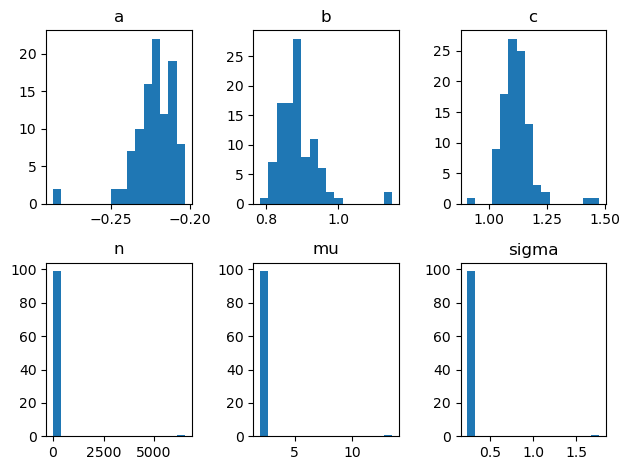

In [123]:
bins = sturges(N_toys)

def edges(d):
    return np.linspace(np.min(d), np.max(d), sturges(len(d)))

fig, ax = plt.subplots(nrows = 2, ncols = 3)

ax[0][0].hist(al, edges(al));
ax[0][0].set_title('a');

ax[0][1].hist(bl, edges(bl));
ax[0][1].set_title('b');

ax[0][2].hist(cl, edges(cl));
ax[0][2].set_title('c');

ax[1][0].hist(nl, edges(nl));
ax[1][0].set_title('n');

ax[1][1].hist(mul, edges(mul));
ax[1][1].set_title('mu');

ax[1][2].hist(sigmal, edges(sigmal));
ax[1][2].set_title('sigma');

plt.tight_layout()